FFM模型采用引入特征域的方式增强了模型的特征交叉能力,但无论如何,FFM只能做二阶的特征交叉,如果继续提高特征交叉的维度,会不可避免地产生组合爆炸和计算复杂度过高的问题。2014年,Facebook提出了基于GBDT+LR组合模型的解决方案。

即利用GBDT自定进行特征筛选，生成新的离散化特征，将这些特征作为新的特征作为Logistic 回归的输入，预测CTR。

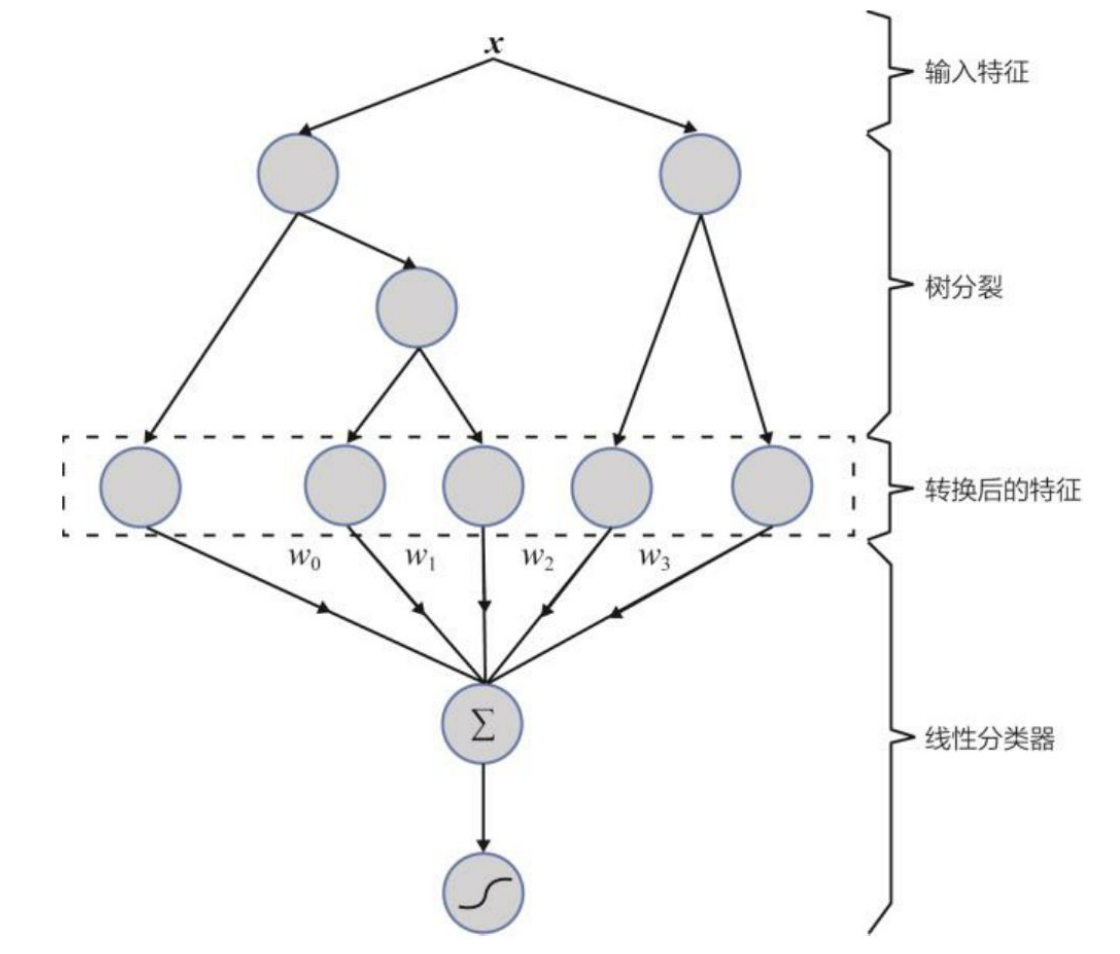

用 GBDT 构建特征工程,利用 LR 预估 CTR 这两步是独立训练的,所以不存在如何将 LR 的梯度回传到 GBDT 这类复杂的问题。

GBDT的基本结构是决策树组成的树林，训练模式是梯度提升。
- GBDT的预测值是所有子树预测值的和:

$$ D(x)=D_1(x) + D_2(x) + D_3(x) + ...$$

- GBDT通过逐一生成决策子树的方式生成整个树林,生成新子树的过程是利用样本标签值与当前树林预测值之间的残差,构建新的子树。

- 生成的过程是以目标拟合函数和已有树林预测结果的残差R(x)为目标:

$$ R(x) = f(x) - D(x)$$

- 准备阶段：
首先整理广告数据，比如用户年龄、广告点击率、设备类型等原始特征。就像整理一份Excel表格，每一行是一个广告展示记录，每一列是不同的特征。对于文字类特征（如设备类型），需要先转换成数字编码。

- 训练GBDT模型：
我们让GBDT模型（比如用100棵小决策树组成的森林）去学习这些数据。每棵小树会根据特征自动做判断，比如：

第一棵树可能先按"用户年龄是否大于30岁"划分

第二棵树可能关注"广告点击率是否高于0.1"

...以此类推

- 生成新特征：
重点来了！当一条广告数据通过这100棵小树时：

每棵树都会把它分到某个"叶子节点"（就像流水线上的分类格子）

记录这条数据在每棵树最终落在哪个格子（比如第1棵树的3号格，第2棵树的5号格...）

把这些位置信息转换成新的编码。比如用100棵树就生成100个新特征，每个特征值表示落在哪个节点。

- 转换编码：
为了更好利用这些位置信息，我们会进行"独热编码"转换：

每棵树单独处理，如果有4个叶子节点就生成4个新特征

用0/1表示是否落到某个节点（比如[0,1,0,0]表示落到该树的2号节点）

最终所有树的编码拼接起来，可能得到几百维的新特征向量

- 使用新特征：
这些新特征实际上记录了：

原始特征的复杂组合关系（比如"年轻用户+高点击率+移动设备"的组合）

数据在不同决策路径上的归属情况
可以把这些新特征直接输入逻辑回归等简单模型，效果往往比直接用原始特征更好。

- 举个例子：
假设有一条广告数据：

用户年龄28岁

广告点击率0.05

设备是手机

通过GBDT后可能发现：

第1棵树把它分到"年轻用户"节点

第2棵树分到"低点击率"节点

第3棵树分到"移动设备"节点
...
最终生成的新特征就反映了"年轻用户在移动端看到低点击率广告"这个组合特征。


***随着树高度的增加，往往能获得更加精确的特征组合，但是可能出现过拟合问题***

事实上,决策树的深度决定了特征交叉的阶数。如果决策树的深度为4,则通过3次节点分裂,最终的叶节点实际上是进行三阶特征组合后的结果,如此强的特征组合能力显然是FM系的模型不具备的。但GBDT容易产生过拟合,以及GBDT的特征转换方式实际上丢失了大量特征的数值信息,因此不能简单地说GBDT的特征交叉能力强

***广义上讲,深度学习模型通过各类网络结构、Embedding层等方法完成特征工程的自动化,都是GBDT+LR开启的特征工程模型化这一趋势的延续。***